# Limes
Synchrounous execution time analysis

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd
import numpy as np
import datetime

In [4]:
df = pd.read_csv("times.csv");
set(df['name'])

{'image_processing',
 'image_processing_no_io',
 'mandelbrotset',
 'mandelbrotset_no_io',
 'nop_cold_start'}

## Cold start analysis

Mean:  6.0383457141424275
Median:  5.985993


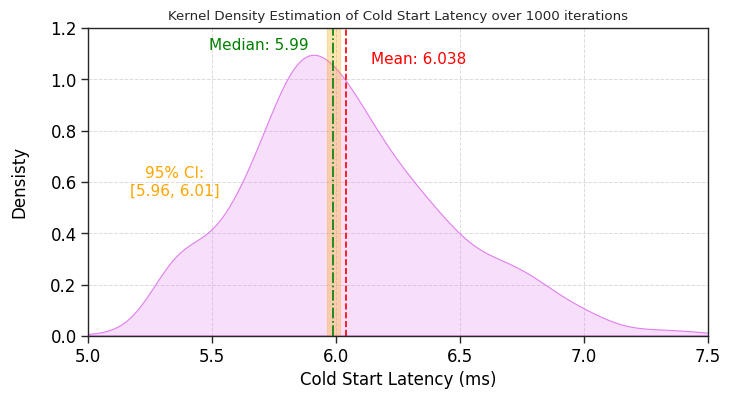

In [5]:
sub_df = df[df['name'] == 'nop_cold_start']

# Convert elapsed time to ms
cold_start_df = pd.DataFrame(columns = ["cold_start_time_ms"])
cold_start_df['cold_start_time_ms'] = sub_df['elapsed_time'].apply(lambda t: t / 1_000_000)
cold_start_df.head()

# Remove outliers
z_scores = st.zscore(cold_start_df['cold_start_time_ms'])
cold_start_df = cold_start_df[(abs(z_scores) < 3)]

# Init plot
sns.set_theme(style='ticks', context='paper')
plt.figure(figsize=(8,4))
plt.title('Kernel Density Estimation of Cold Start Latency over 1000 iterations')
plt.xlabel('Cold Start Latency (ms)', fontsize=12, color='black')
plt.ylabel('Densisty', fontsize=12, color='black', labelpad=16)
plt.xticks(fontsize=12, color='black')
plt.yticks(fontsize=12, color='black')
plt.grid(visible=True, which='major', linestyle='--', linewidth=0.7, alpha=0.7)

# Get data
mean = cold_start_df['cold_start_time_ms'].mean()
median = cold_start_df['cold_start_time_ms'].median()
print("Mean: ", mean)
print("Median: ", median)

# Confidence Interval
ci = st.bootstrap((cold_start_df['cold_start_time_ms'],), np.median, confidence_level=0.95, n_resamples=10000).confidence_interval
ci_lower = ci[0]
ci_upper = ci[1]

plt.ylim(0, 1.2)
plt.xlim(5, 7.5)

# Plot data
sns.kdeplot(data=cold_start_df, color='#e07eee', fill=True, x='cold_start_time_ms')

# Add stats indicators
plt.axvline(mean, color='red', linestyle='--', linewidth=1.2, label=f'Mean: {mean:.2f}')
plt.axvline(median, color='green', linestyle='-.', linewidth=1.2, label=f'Median: {median:.2f}')
plt.fill_betweenx(
    y = [0, 6],
    x1 = ci_lower,
    x2 = ci_upper,
    color = 'orange',
    alpha = 0.3,
    label=f'95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]'
)

# Add labels
ylim = plt.gca().get_ylim()
plt.text(mean + 0.1, ylim[1] * 0.90, f'Mean: {mean:.3f}', color='red', fontsize=11, ha='left', va='center')
plt.text(median - 0.30, ylim[1] * 0.945, f'Median: {median:.2f}', color='green', fontsize=11, ha='center', va='center')
plt.text(5.35, ylim[1] * 0.50, f'95% CI:\n[{ci_lower:.2f}, {ci_upper:.2f}]', color='orange', fontsize=11, ha='center', va='center')

# Save results
plt.savefig('./plots/cold_start_density.svg', format="svg")
plt.savefig('./plots/cold_start_density.pdf', format="pdf", bbox_inches = 'tight')
plt.show()

## Execution time analysis
There are 5 tables, 2 of them are the same function, but without the use of read and write kernel api. This is done to show a current problem in the implementation of wasmtime which drasticly slowdown the function execution time due to this operations
### Image processing

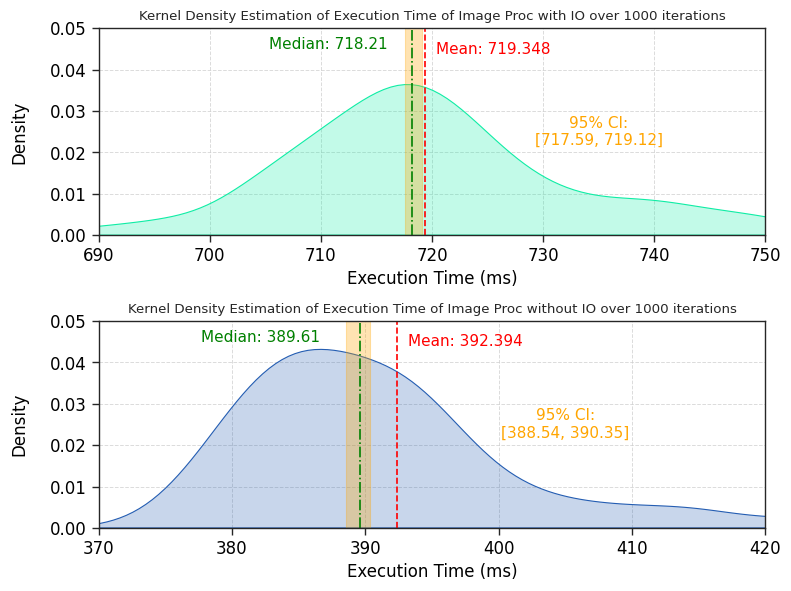

In [6]:
img_proc_df = df[df['name'] == 'image_processing'][['elapsed_time']].rename(columns = {'elapsed_time': 'exec_time'})
img_proc_no_io_df = df[df['name'] == 'image_processing_no_io'][['elapsed_time']].rename(columns = {'elapsed_time': 'exec_time'})

# Reset index
img_proc_df.index = range(1, len(img_proc_df) + 1)
img_proc_no_io_df.index = range(1, len(img_proc_no_io_df) + 1)

# Convertings times
img_proc_df['exec_time'] = img_proc_df['exec_time'].apply(lambda t: t / 1_000_000)
img_proc_no_io_df['exec_time'] = img_proc_no_io_df['exec_time'].apply(lambda t: t / 1_000_000)

# Init plot
sns.set_theme(style='ticks', context='paper')
plt.figure(figsize=(8,6))

# Plot image processing with io
plt.subplot(2, 1, 1)
plt.title('Kernel Density Estimation of Execution Time of Image Proc with IO over 1000 iterations')
plt.xlabel('Execution Time (ms)', fontsize=12, color='black')
plt.ylabel('Density', fontsize=12, color='black', labelpad=16)
plt.xticks(fontsize=12, color='black')
plt.yticks(fontsize=12, color='black')
plt.grid(visible=True, which='major', linestyle='--', linewidth=0.7, alpha=0.7)

mean = img_proc_df['exec_time'].mean()
median = img_proc_df['exec_time'].median()

# Confidence Interval
ci = st.bootstrap((img_proc_df['exec_time'],), np.median, confidence_level=0.95, n_resamples=10000).confidence_interval
ci_lower = ci[0]
ci_upper = ci[1]

# Size
plt.ylim(0, 0.05)
plt.xlim(690, 750)

#Plot data
sns.kdeplot(data = img_proc_df, color = '#0feda5', fill=True, x='exec_time')

# Add stats indicators
plt.axvline(mean, color='red', linestyle='--', linewidth=1.2, label=f'Mean: {mean:.2f}')
plt.axvline(median, color='green', linestyle='-.', linewidth=1.2, label=f'Median: {median:.2f}')
plt.fill_betweenx(
    y = [0, 0.1],
    x1 = ci_lower,
    x2 = ci_upper,
    color = 'orange',
    alpha = 0.3,
    label=f'95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]'
)

# Add labels
ylim = plt.gca().get_ylim()
plt.text(mean + 1, ylim[1] * 0.90, f'Mean: {mean:.3f}', color='red', fontsize=11, ha='left', va='center')
plt.text(median - 7.5, ylim[1] * 0.92, f'Median: {median:.2f}', color='green', fontsize=11, ha='center', va='center')
plt.text(735, ylim[1] * 0.50, f'95% CI:\n[{ci_lower:.2f}, {ci_upper:.2f}]', color='orange', fontsize=11, ha='center', va='center')

# Plot image processing without io
plt.subplot(2, 1, 2)
plt.title('Kernel Density Estimation of Execution Time of Image Proc without IO over 1000 iterations')
plt.xlabel('Execution Time (ms)', fontsize=12, color='black')
plt.ylabel('Density', fontsize=12, color='black', labelpad=16)
plt.xticks(fontsize=12, color='black')
plt.yticks(fontsize=12, color='black')
plt.grid(visible=True, which='major', linestyle='--', linewidth=0.7, alpha=0.7)

mean = img_proc_no_io_df['exec_time'].mean()
median = img_proc_no_io_df['exec_time'].median()

# Confidence Interval
ci = st.bootstrap((img_proc_no_io_df['exec_time'],), np.median, confidence_level=0.95, n_resamples=10000).confidence_interval
ci_lower = ci[0]
ci_upper = ci[1]

# Size
plt.ylim(0, 0.05)
plt.xlim(370, 420)

#Plot data
sns.kdeplot(data = img_proc_no_io_df, color = '#245db2', fill=True, x='exec_time')

# Add stats indicators
plt.axvline(mean, color='red', linestyle='--', linewidth=1.2, label=f'Mean: {mean:.2f}')
plt.axvline(median, color='green', linestyle='-.', linewidth=1.2, label=f'Median: {median:.2f}')
plt.fill_betweenx(
    y = [0, 0.1],
    x1 = ci_lower,
    x2 = ci_upper,
    color = 'orange',
    alpha = 0.3,
    label=f'95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]'
)

# Add labels
ylim = plt.gca().get_ylim()
plt.text(mean + 0.8, ylim[1] * 0.90, f'Mean: {mean:.3f}', color='red', fontsize=11, ha='left', va='center')
plt.text(median - 7.5, ylim[1] * 0.92, f'Median: {median:.2f}', color='green', fontsize=11, ha='center', va='center')
plt.text(405, ylim[1] * 0.50, f'95% CI:\n[{ci_lower:.2f}, {ci_upper:.2f}]', color='orange', fontsize=11, ha='center', va='center')

# Save and show
plt.tight_layout()
plt.savefig('./plots/img_proc.svg', format="svg")
plt.savefig('./plots/img_proc.pdf', format="pdf", bbox_inches = 'tight')
plt.show()

### Mandelbrotset

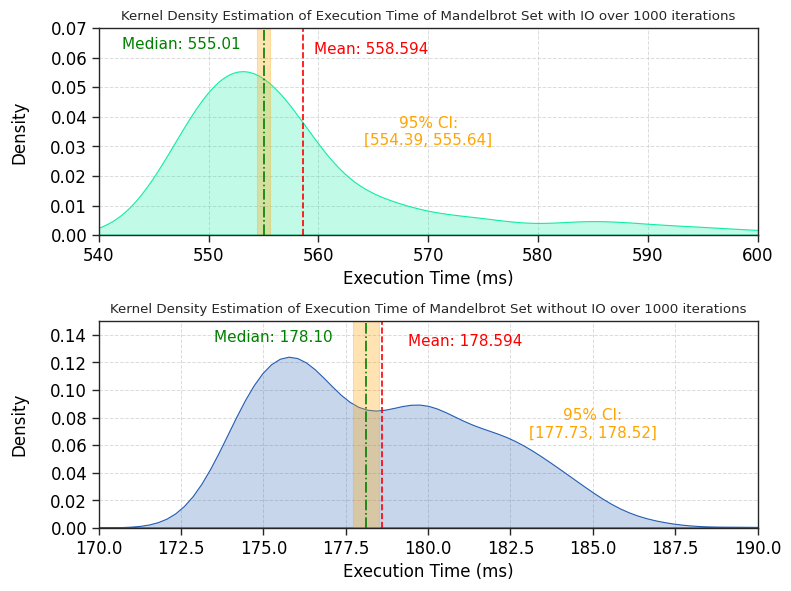

In [34]:
mbs_df = df[df['name'] == 'mandelbrotset'][['elapsed_time']].rename(columns = {'elapsed_time': 'exec_time'})
mbs_no_io_df = df[df['name'] == 'mandelbrotset_no_io'][['elapsed_time']].rename(columns = {'elapsed_time': 'exec_time'})

# Reset index
mbs_df.index = range(1, len(mbs_df) + 1)
mbs_no_io_df.index = range(1, len(mbs_no_io_df) + 1)

# Convertings times
mbs_df['exec_time'] = mbs_df['exec_time'].apply(lambda t: t / 1_000_000)
mbs_no_io_df['exec_time'] = mbs_no_io_df['exec_time'].apply(lambda t: t / 1_000_000)

# Init plot
sns.set_theme(style='ticks', context='paper')
plt.figure(figsize=(8,6))

# Plot image processing with io
plt.subplot(2, 1, 1)
plt.title('Kernel Density Estimation of Execution Time of Mandelbrot Set with IO over 1000 iterations')
plt.xlabel('Execution Time (ms)', fontsize=12, color='black')
plt.ylabel('Density', fontsize=12, color='black', labelpad=16)
plt.xticks(fontsize=12, color='black')
plt.yticks(fontsize=12, color='black')
plt.grid(visible=True, which='major', linestyle='--', linewidth=0.7, alpha=0.7)

mean = mbs_df['exec_time'].mean()
median = mbs_df['exec_time'].median()

# Confidence Interval
ci = st.bootstrap((mbs_df['exec_time'],), np.median, confidence_level=0.95, n_resamples=10000).confidence_interval
ci_lower = ci[0]
ci_upper = ci[1]

# Size
plt.ylim(0, 0.07)
plt.xlim(540, 600)

#Plot data
sns.kdeplot(data = mbs_df, color = '#0feda5', fill=True, x='exec_time')

# Add stats indicators
plt.axvline(mean, color='red', linestyle='--', linewidth=1.2, label=f'Mean: {mean:.2f}')
plt.axvline(median, color='green', linestyle='-.', linewidth=1.2, label=f'Median: {median:.2f}')
plt.fill_betweenx(
    y = [0, 0.1],
    x1 = ci_lower,
    x2 = ci_upper,
    color = 'orange',
    alpha = 0.3,
    label=f'95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]'
)

# Add labels
ylim = plt.gca().get_ylim()
plt.text(mean + 1, ylim[1] * 0.90, f'Mean: {mean:.3f}', color='red', fontsize=11, ha='left', va='center')
plt.text(median - 7.5, ylim[1] * 0.92, f'Median: {median:.2f}', color='green', fontsize=11, ha='center', va='center')
plt.text(570, ylim[1] * 0.50, f'95% CI:\n[{ci_lower:.2f}, {ci_upper:.2f}]', color='orange', fontsize=11, ha='center', va='center')

# Plot image processing without io
plt.subplot(2, 1, 2)
plt.title('Kernel Density Estimation of Execution Time of Mandelbrot Set without IO over 1000 iterations')
plt.xlabel('Execution Time (ms)', fontsize=12, color='black')
plt.ylabel('Density', fontsize=12, color='black', labelpad=16)
plt.xticks(fontsize=12, color='black')
plt.yticks(fontsize=12, color='black')
plt.grid(visible=True, which='major', linestyle='--', linewidth=0.7, alpha=0.7)

mean = mbs_no_io_df['exec_time'].mean()
median = mbs_no_io_df['exec_time'].median()

# Confidence Interval
ci = st.bootstrap((mbs_no_io_df['exec_time'],), np.median, confidence_level=0.95, n_resamples=10000).confidence_interval
ci_lower = ci[0]
ci_upper = ci[1]

# Size
plt.ylim(0, 0.15)
plt.xlim(170, 190)

#Plot data
sns.kdeplot(data = mbs_no_io_df, color = '#245db2', fill=True, x='exec_time')

# Add stats indicators
plt.axvline(mean, color='red', linestyle='--', linewidth=1.2, label=f'Mean: {mean:.2f}')
plt.axvline(median, color='green', linestyle='-.', linewidth=1.2, label=f'Median: {median:.2f}')
plt.fill_betweenx(
    y = [0, 0.15],
    x1 = ci_lower,
    x2 = ci_upper,
    color = 'orange',
    alpha = 0.3,
    label=f'95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]'
)

# Add labels
ylim = plt.gca().get_ylim()
plt.text(mean + 0.8, ylim[1] * 0.90, f'Mean: {mean:.3f}', color='red', fontsize=11, ha='left', va='center')
plt.text(median - 2.8, ylim[1] * 0.92, f'Median: {median:.2f}', color='green', fontsize=11, ha='center', va='center')
plt.text(185, ylim[1] * 0.50, f'95% CI:\n[{ci_lower:.2f}, {ci_upper:.2f}]', color='orange', fontsize=11, ha='center', va='center')

# Save and show
plt.tight_layout()
plt.savefig('./plots/mandelbrotset.svg', format="svg")
plt.savefig('./plots/mandelbrotset.pdf', format="pdf", bbox_inches = 'tight')
plt.show()